# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
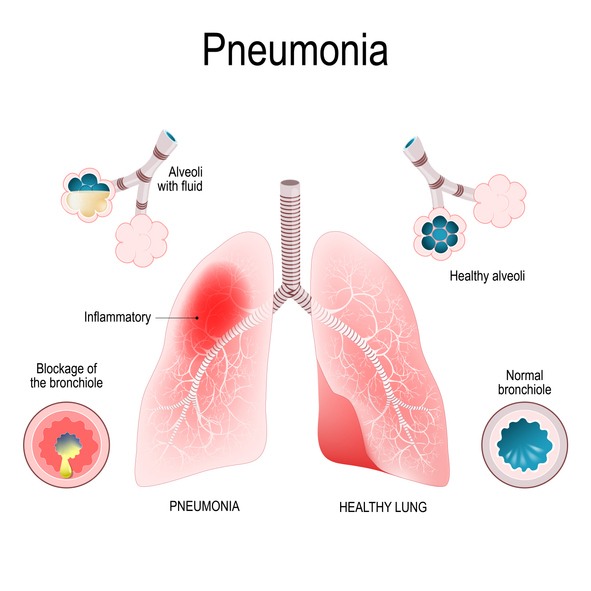

# Importing the necessary libraries

In [2]:
# Import essential libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools
import keras
import seaborn as sns
from glob import glob
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers.normalization import BatchNormalization

# For Resnet
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import ResNet50
from keras import regularizers

# For snapshot Ensemble
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model

# Description of the Pneumonia Dataset
**, X-ray images obtained three different sources were used for the diagnosis of COVID-19. A COVID-19 X-ray image database was developed by a team of researchers from Qatar University, Doha, Qatar and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. In the current release, there are 219 COVID-19 positive images, 1341 normal images and 1345 viral pneumonia images .**

In [4]:
chest_directory = os.path.join('..', 'input/covid19-radiography-database/COVID-19 Radiography Database/')

# creating a directory for all images present with us and bringing them under same directory
image_directory = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(chest_directory, '*', '*.png'))}

In [5]:
covidPaths = []
for dirname, _, filenames in os.walk(os.path.join(chest_directory, 'COVID-19')):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            covidPaths.append(os.path.join(dirname, filename))

In [6]:
normalPaths = []
for dirname, _, filenames in os.walk(os.path.join(chest_directory, 'NORMAL')):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            normalPaths.append(os.path.join(dirname, filename))

In [7]:
pneumoniaPaths = []
for dirname, _, filenames in os.walk(os.path.join(chest_directory, 'Viral Pneumonia')):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            pneumoniaPaths.append(os.path.join(dirname, filename))

In [8]:
df = pd.DataFrame(columns = ['path', 'label'])

In [9]:
# labels for covid:0, pneumonia:1, normal:2

for index1 in covidPaths:
    df=df.append({'path' : str(index1) , 'label' : 0} , ignore_index=True)
for index2 in pneumoniaPaths:
    df=df.append({'path' : str(index2) , 'label' : 1} , ignore_index=True)
for index3 in normalPaths:
    df=df.append({'path' : str(index3) , 'label' : 2} , ignore_index=True)

In [10]:
df.head()

,path,label
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


In [11]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = r
    
    return gray

In [12]:
# Resizing images to 100 x 100
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [13]:
for index in range(len(df['image'])):
    img = Image.fromarray(df['image'][index])
    if img.mode == 'RGB':
        df['image'][index] = rgb2gray(df['image'][index])

In [14]:
import cv2

for i in range(len(df['image'])):
    gray = df['image'][i]
    df['image'][i] = cv2.merge([gray,gray,gray])

In [15]:
df.head()

,path,label,image
0,../input/covid19-radiography-database/COVID-19...,0,"[[[87, 87, 87], [0, 0, 0], [3, 3, 3], [3, 3, 3..."
1,../input/covid19-radiography-database/COVID-19...,0,"[[[20, 20, 20], [15, 15, 15], [13, 13, 13], [1..."
2,../input/covid19-radiography-database/COVID-19...,0,"[[[0, 0, 0], [125, 125, 125], [255, 255, 255],..."
3,../input/covid19-radiography-database/COVID-19...,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,../input/covid19-radiography-database/COVID-19...,0,"[[[114, 114, 114], [156, 156, 156], [189, 189,..."


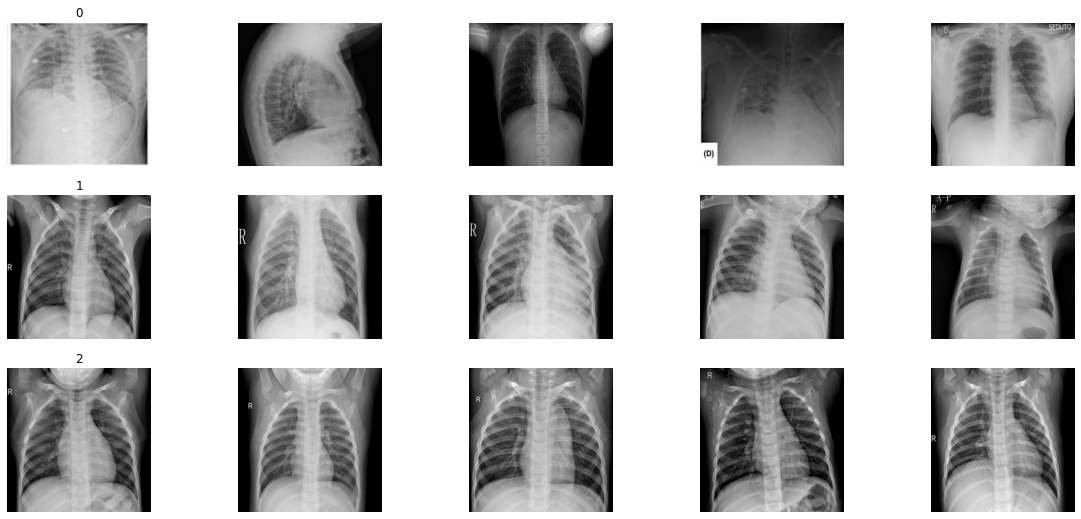

In [16]:
# Printing Sample images for each lesion type
n_samples = 5
num_classes = 3
fig, m_axs = plt.subplots(num_classes, n_samples, figsize = (4*n_samples, 3*num_classes))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [18]:
df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    2905
Name: image, dtype: int64

In [19]:
# Print no. of instances of each class present to balace the data
df['label'].value_counts()

1    1345
2    1341
0     219
Name: label, dtype: int64

In [20]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [6,0,0] # These values are calculated to balance the data
for i in range(num_classes):
    if data_aug_rate[i]:
        df=df.append([df.loc[df['label'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df['label'].value_counts()

1    1345
2    1341
0    1314
Name: label, dtype: int64

In [21]:
features=df.drop(columns=['label'],axis=1)
target=df['label']

In [22]:
x_train = np.asarray(df['image'].tolist())
x_test = np.asarray(test_df['image'].tolist())

In [23]:
# Normalizing the data
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [24]:
y_train = to_categorical(df['label'], num_classes = num_classes)
y_test = to_categorical(test_df['label'], num_classes = num_classes)

In [25]:
# Splitting training data and validation data
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.20, random_state = 3)

In [62]:
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

(3200, 224, 224, 3)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [27]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [28]:
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


# Training the Model

In [29]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
import keras
#import keras.metrics
from keras.models import Sequential,Input,Model
input_tensor = Input(shape=(224,224,3))
base_model = ResNet50(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(3, activation = 'softmax')(x)
model = Model(base_model.input,x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [30]:
optimizer = Adam(lr = 0.0001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [64]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
x_train.shape

(3200, 224, 224, 3)

In [32]:
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=10),
    steps_per_epoch=len(x_train) / 10,
    epochs=20,
    verbose=1,
    callbacks=[learning_rate_reduction],
    validation_data= datagen.flow(x_validate, y_validate)
)

Epoch 1/20
320/320 [==============================] - 54s 168ms/step - loss: 0.2957 - accuracy: 0.8984 - val_loss: 1.5293 - val_accuracy: 0.3913 - lr: 1.0000e-04
Epoch 2/20
320/320 [==============================] - 52s 163ms/step - loss: 0.1516 - accuracy: 0.9472 - val_loss: 3.8716 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 3/20
320/320 [==============================] - 52s 161ms/step - loss: 0.1231 - accuracy: 0.9606 - val_loss: 0.1583 - val_accuracy: 0.9488 - lr: 1.0000e-04
Epoch 4/20
320/320 [==============================] - 53s 164ms/step - loss: 0.0977 - accuracy: 0.9650 - val_loss: 0.0669 - val_accuracy: 0.9775 - lr: 1.0000e-04
Epoch 5/20
320/320 [==============================] - 53s 165ms/step - loss: 0.0932 - accuracy: 0.9694 - val_loss: 0.0893 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 6/20
320/320 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.9619
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
320/320 [====

In [33]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

19/19 [==============================] - 1s 63ms/step - loss: 0.0206 - accuracy: 0.9966
Loss of the model is -  0.0205914955586195
19/19 [==============================] - 1s 57ms/step - loss: 0.0206 - accuracy: 0.9966
Accuracy of the model is -  99.65576529502869 %


# Analysis after Model Training

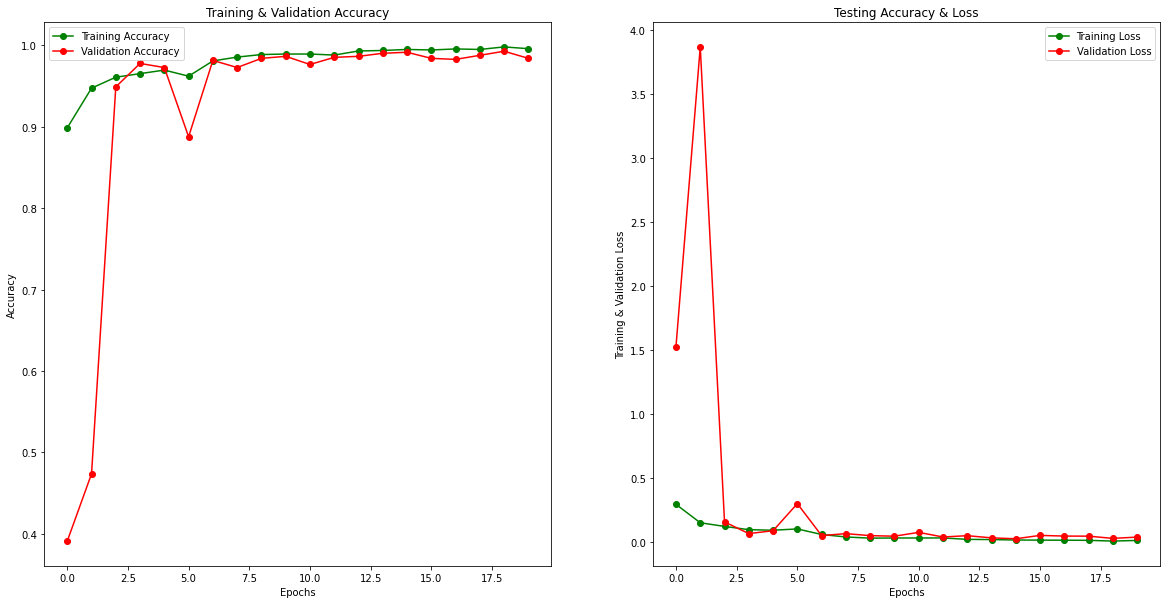

In [36]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [66]:
from sklearn.metrics import classification_report
pred = model.predict(x_validate)
print(classification_report(np.argmax(y_validate, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       267
           1       0.99      0.97      0.98       266
           2       0.97      0.99      0.98       267

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



(3200, 224, 224, 3)

In [55]:
x_test.shape

(581, 224, 224, 3)

In [68]:
cm = confusion_matrix(np.argmax(y_validate, axis = 1),np.argmax(pred, axis = 1))
cm

array([[267,   0,   0],
       [  0, 259,   7],
       [  0,   3, 264]])

In [69]:
cm = pd.DataFrame(cm , index = ['0','1', '2'] , columns = ['0','1', '2'])

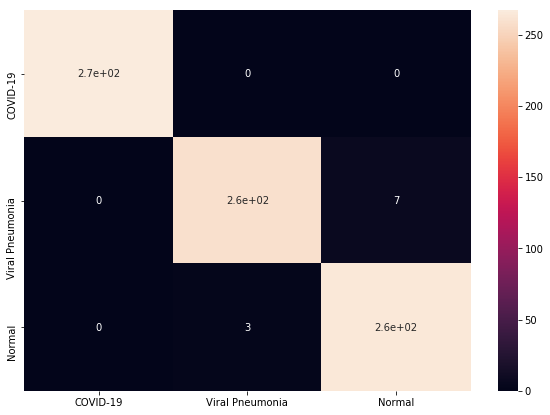

In [2]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
array =[[267,0,0],
        [0,259,7],
        [0,3,264]]
df_cm = pd.DataFrame(array, index = [i for i in ["COVID-19", "Viral Pneumonia", "Normal"]],
                  columns = [i for i in ["COVID-19", "Viral Pneumonia", "Normal"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)